In [ ]:
#@title Library imports
import numpy as np
from sklearn import mixture
from scipy.io import loadmat
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
#@title Functions

def CheckIfResponsed(theta,x,sigma1,sigma2,MaxRate):
    V = ObservationModel(theta, x, sigma1,MaxRate)
    return np.random.binomial(1,V)

def ObservationModel(theta, x, sigma, MaxRate):
    # Make sure either theta is an array, otherwise it always returns 1
    return np.exp((x-theta)*(theta-x)/(4*sigma*sigma))*MaxRate

def UpdateBelief2(belief1,ResponseFlag,x,VocalizationSpace, sigma1, MaxRate):
    if ResponseFlag:
        belief = belief1*ObservationModel(VocalizationSpace,x,sigma1,MaxRate)
        belief = belief/belief.sum() #normalizar belief
    else:
        belief = belief1*(1-ObservationModel(VocalizationSpace,x,sigma1,MaxRate))
        belief = belief/belief.sum() #normalizar belief
    return belief

def deviations_on_time_sim(x,y,binsize,overlap):
    spacing = binsize - overlap
    n_bins = int(min(1800,np.max(x))//spacing)
    deviations = []
    for bin in range(n_bins):
        time_indx = (x >= bin*spacing)*(x < bin*spacing + binsize)
        yi = y[time_indx]
        deviations.append(np.std(yi)/np.mean(yi))
    return np.array(deviations)

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k*(x-x0)))+b

def ScatterPlot(x,y,ax,reduce=1):

    n_max = x.shape[0]
    ind_reduced = np.random.choice(range(0, n_max),n_max//reduce)
    ax.plot(x[ind_reduced],y[ind_reduced],'.k')
    return

def DeviationSigmoid(xdata,ydata,ax):
    #popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=(-1,np.inf),maxfev=10000)
    p0 = [-max(ydata)+min(ydata),max(xdata)/2,0.1,max(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',bounds=(-1,np.inf),maxfev=20000)

    x = xdata
    y = sigmoid(x, *popt)
    ax.plot(xdata, ydata, '.', label='data')
    ax.plot(x,y, label='fit')
    ax.legend(loc='best')
    #print(r2_score(ydata, y))
    return

def Clustering(xdata,ydata,ax):
    indxs = xdata > np.max(xdata)/2
    durationsinterest = np.array([[ydata[indxs][i] for i in range(np.sum(indxs))]]).T
    X = durationsinterest
    model1 = mixture.GaussianMixture(1).fit(X)
    model2 = mixture.GaussianMixture(2,n_init=10).fit(X)
    model3 = mixture.GaussianMixture(3,n_init=10).fit(X)
    model4 = mixture.GaussianMixture(4,n_init=10).fit(X)
    model5 = mixture.GaussianMixture(5).fit(X)
    ax.plot([1,2,3,4,5],[model1.bic(X),model2.bic(X),model3.bic(X),model4.bic(X),model5.bic(X)])

def PDFs(xdata,ydata,k,ax):
    # k is the number of cluster
    indxs = xdata > np.max(xdata)/2
    durationsinterest = np.array([[ydata[indxs][i] for i in range(np.sum(indxs))]]).T
    X = durationsinterest
    model = mixture.GaussianMixture(k,n_init=10).fit(X)
    x_axis = np.arange(0, 5, 0.01)
    # Calculating mean and standard deviation
    mean = model.means_[0,0]
    sd = np.sqrt(model.covariances_[0,0,0])
    gaus0 = norm.pdf(x_axis, mean, sd)
    mean = model.means_[1,0]
    sd = np.sqrt(model.covariances_[1,0,0])
    gaus1 = norm.pdf(x_axis, mean, sd)
    if k == 3:
        mean = model.means_[2,0]
        sd = np.sqrt(model.covariances_[2,0,0])
        gaus2 = norm.pdf(x_axis, mean, sd)
        ax.plot(gaus2,x_axis)
    ax.plot(gaus0,x_axis)
    ax.plot(gaus1,x_axis)
    #ax.gca().invert_yaxis()

In [ ]:
#@title Read data

# All data is saved to the NumPy-specific binary file data.npz
npz = np.load('data.npz')

# Pre-loaded simulation from active sampling model because it takes
# a long time to run
vocs_pac_boot = npz['vocs_pac_boot']

# Real marmoset data from:
# "Liao, D.A., Zhang, Y.S., Cai, L.X., and Ghazanfar, A.A. (2018).
# Internal states and extrinsic factors both determine monkey vocal production.
# Proceedings of the National Academy of Sciences 115, 3978-3983."
duration_list = npz['duration_list'] # Element i in this array is the duration of the i-th recorded call
start_list = npz['start_list'] # Element i in this array is the time the i-th call started in it's session
context_id_list = npz['context_id_list']  # Element i in this array represents in which context the call was recorded
# The contexts are alone (1), occluded far (2), visible close (3), and visible far (4). Please refer to the original
# paper for more details about the contexts.

In [ ]:
#@title Social sensing model data

vocs = []
times = []
for i in range(vocs_pac_boot.size):
    pac = vocs_pac_boot[i//vocs_pac_boot.shape[1],i%vocs_pac_boot.shape[1]]
    if pac != 2.5:
        vocs.append(pac)
        times.append(i%vocs_pac_boot.shape[1])
vocs_EID = np.array(vocs)
times_EID = np.array(times)*18/5

#ScatterPlot(vocs_EID,times_EID)


In [ ]:
#@title Accommodation model data

VocalizationSpaceSize = 100
VocalizationSpace = np.linspace(-5, 5, VocalizationSpaceSize)
sigma1 = 0.2
sigma2 = 1.6
MaxRate = 0.4
spontaneous_rate = 0.6
N_iterations = 500//2
n_boot = 50

theta = -2

MeasurementSpace = np.linspace(0,MaxRate,int(MaxRate*10))

vocs_pac_boot_acc = np.ones([n_boot, 2*N_iterations])-100

#for bootstrap_iter in range(n_boot):
for bootstrap_iter in range(n_boot):

    belief1 = np.ones(len(VocalizationSpace))
    belief1 /= belief1.sum()

    belief2 = np.ones(len(VocalizationSpace))
    belief2 /= belief2.sum()

    ResponseFlag = 0
    V1to2 = 0
    V2to1 = 0

    # Initial vocalizations
    iteration = 0

#    for i in tqdm(range(N_iterations)):
    for i in range(N_iterations):

        # Agent 1
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            x = np.random.choice(VocalizationSpace,1,p=belief1)
            vocs_pac_boot_acc[bootstrap_iter,iteration] = x
            ResponseFlag = CheckIfResponsed(theta,x,sigma1,sigma2,MaxRate)
            belief1 = UpdateBelief2(belief1, ResponseFlag, x, VocalizationSpace, sigma1,MaxRate)
            belief1 /= belief1.sum()

        iteration += 1

        # Agent 2
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            x = np.random.choice(VocalizationSpace,1,p=belief2)
            vocs_pac_boot_acc[bootstrap_iter,iteration] = x
            ResponseFlag = CheckIfResponsed(theta,x,sigma1,sigma2,MaxRate)
            belief2 = UpdateBelief2(belief2, ResponseFlag, x, VocalizationSpace, sigma1,MaxRate)
            belief2 /= belief2.sum()

        iteration += 1

vocs_pac_boot_acc += 5
vocs_pac_boot_acc /= 2

vocs = []
times = []
for i in range(vocs_pac_boot_acc.size):
    pac = vocs_pac_boot_acc[i//vocs_pac_boot_acc.shape[1],i%vocs_pac_boot_acc.shape[1]]
    if pac > -20:
        vocs.append(pac)
        times.append(i%vocs_pac_boot_acc.shape[1])
vocs_acc = np.array(vocs)
times_acc = np.array(times)*18/5

#ScatterPlot(times_acc,vocs_acc)

In [ ]:
# @title No update model data

#VocalizationSpaceSize = 100
VocalizationSpaceSize = 50
VocalizationSpace = np.linspace(-5, 5, VocalizationSpaceSize)
sigma1 = 0.9
sigma2 = 0.3
MaxRate = 0.5
spontaneous_rate = 0.8
N_iterations = 500//2
n_boot = 50

durhist = np.histogram(vocs_EID[times_EID>250],50)

theta = -2

MeasurementSpace = np.linspace(0,MaxRate,int(MaxRate*10))

vocs_pac_boot_random = np.ones([n_boot, 2*N_iterations])-100

#for bootstrap_iter in range(n_boot):
for bootstrap_iter in range(n_boot):

    belief1 = durhist[0]/durhist[0].sum()
    belief2 = durhist[0]/durhist[0].sum()

    ResponseFlag = 0
    V1to2 = 0
    V2to1 = 0

    # Initial vocalizations
    iteration = 0

#    for i in tqdm(range(N_iterations)):
    for i in range(N_iterations):

        # Agent 1
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            x = np.random.choice(VocalizationSpace,1,p=belief1)
            vocs_pac_boot_random[bootstrap_iter,iteration] = x
            ResponseFlag = CheckIfResponsed(theta,x,sigma1,sigma2,MaxRate)

        iteration += 1

        # Agent 2
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            x = np.random.choice(VocalizationSpace,1,p=belief2)
            vocs_pac_boot_random[bootstrap_iter,iteration] = x
            ResponseFlag = CheckIfResponsed(theta,x,sigma1,sigma2,MaxRate)

        iteration += 1

vocs_pac_boot_random += 5
vocs_pac_boot_random /= 2

vocs = []
times = []
for i in range(vocs_pac_boot_random.size):
    pac = vocs_pac_boot_random[i//vocs_pac_boot_random.shape[1],i%vocs_pac_boot_random.shape[1]]
    if pac > -20:
        vocs.append(pac)
        times.append(i%vocs_pac_boot_random.shape[1])
vocs_noupdate = np.array(vocs)
times_noupdate = np.array(times)*18/5

#ScatterPlot(times_noupdate,vocs_noupdate)

In [ ]:
# @title Occluded and visible data

Occ_inds = context_id_list == 2
timeind = start_list <= 1800
times_occ = start_list[Occ_inds*timeind]
vocs_occ = duration_list[Occ_inds*timeind]

Vis_inds = context_id_list == 4
times_vis = start_list[Vis_inds*timeind]
vocs_vis = duration_list[Vis_inds*timeind]

#ScatterPlot(times_visible,vocs_visible)

In [ ]:
#@title Deviations and sigmoid

deviations_EID = deviations_on_time_sim(times_EID, vocs_EID,7,0)
deviations_xdata = np.linspace(0,1800,len(deviations_EID))
deviations_acc = deviations_on_time_sim(times_acc, vocs_acc,7,0)
deviations_noupdate = deviations_on_time_sim(times_noupdate, vocs_noupdate,7,0)
deviations_occ = deviations_on_time_sim(times_occ, vocs_occ,30,10)
deviations_xrealdata = np.linspace(0,min(1800,np.max(times_occ)),len(deviations_occ))
deviations_vis = deviations_on_time_sim(times_vis, vocs_vis,30,10)

#DeviationSigmoid(deviations_xdata,deviations_EID)
#DeviationSigmoid(deviations_xdata,deviations_acc)
#DeviationSigmoid(deviations_xdata,deviations_noupdate)
#DeviationSigmoid(deviations_xrealdata,deviations_occ)
#DeviationSigmoid(deviations_xrealdata,deviations_vis)

In [ ]:
#@title Clustering

#Clustering(times_EID,vocs_EID)
#Clustering(times_acc,vocs_acc)
#Clustering(times_noupdate,vocs_noupdate)
#Clustering(times_occ,vocs_occ)
#Clustering(times_vis,vocs_vis)

In [ ]:
#@title PDFs

#PDFs(times_EID,vocs_EID,3)
#PDFs(times_acc,vocs_acc,2)
#PDFs(times_noupdate,vocs_noupdate,3)
#PDFs(times_occ,vocs_occ,3)
#PDFs(times_vis,vocs_vis,3)


<ipython-input-2-0205c1372505>:31: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0)))+b


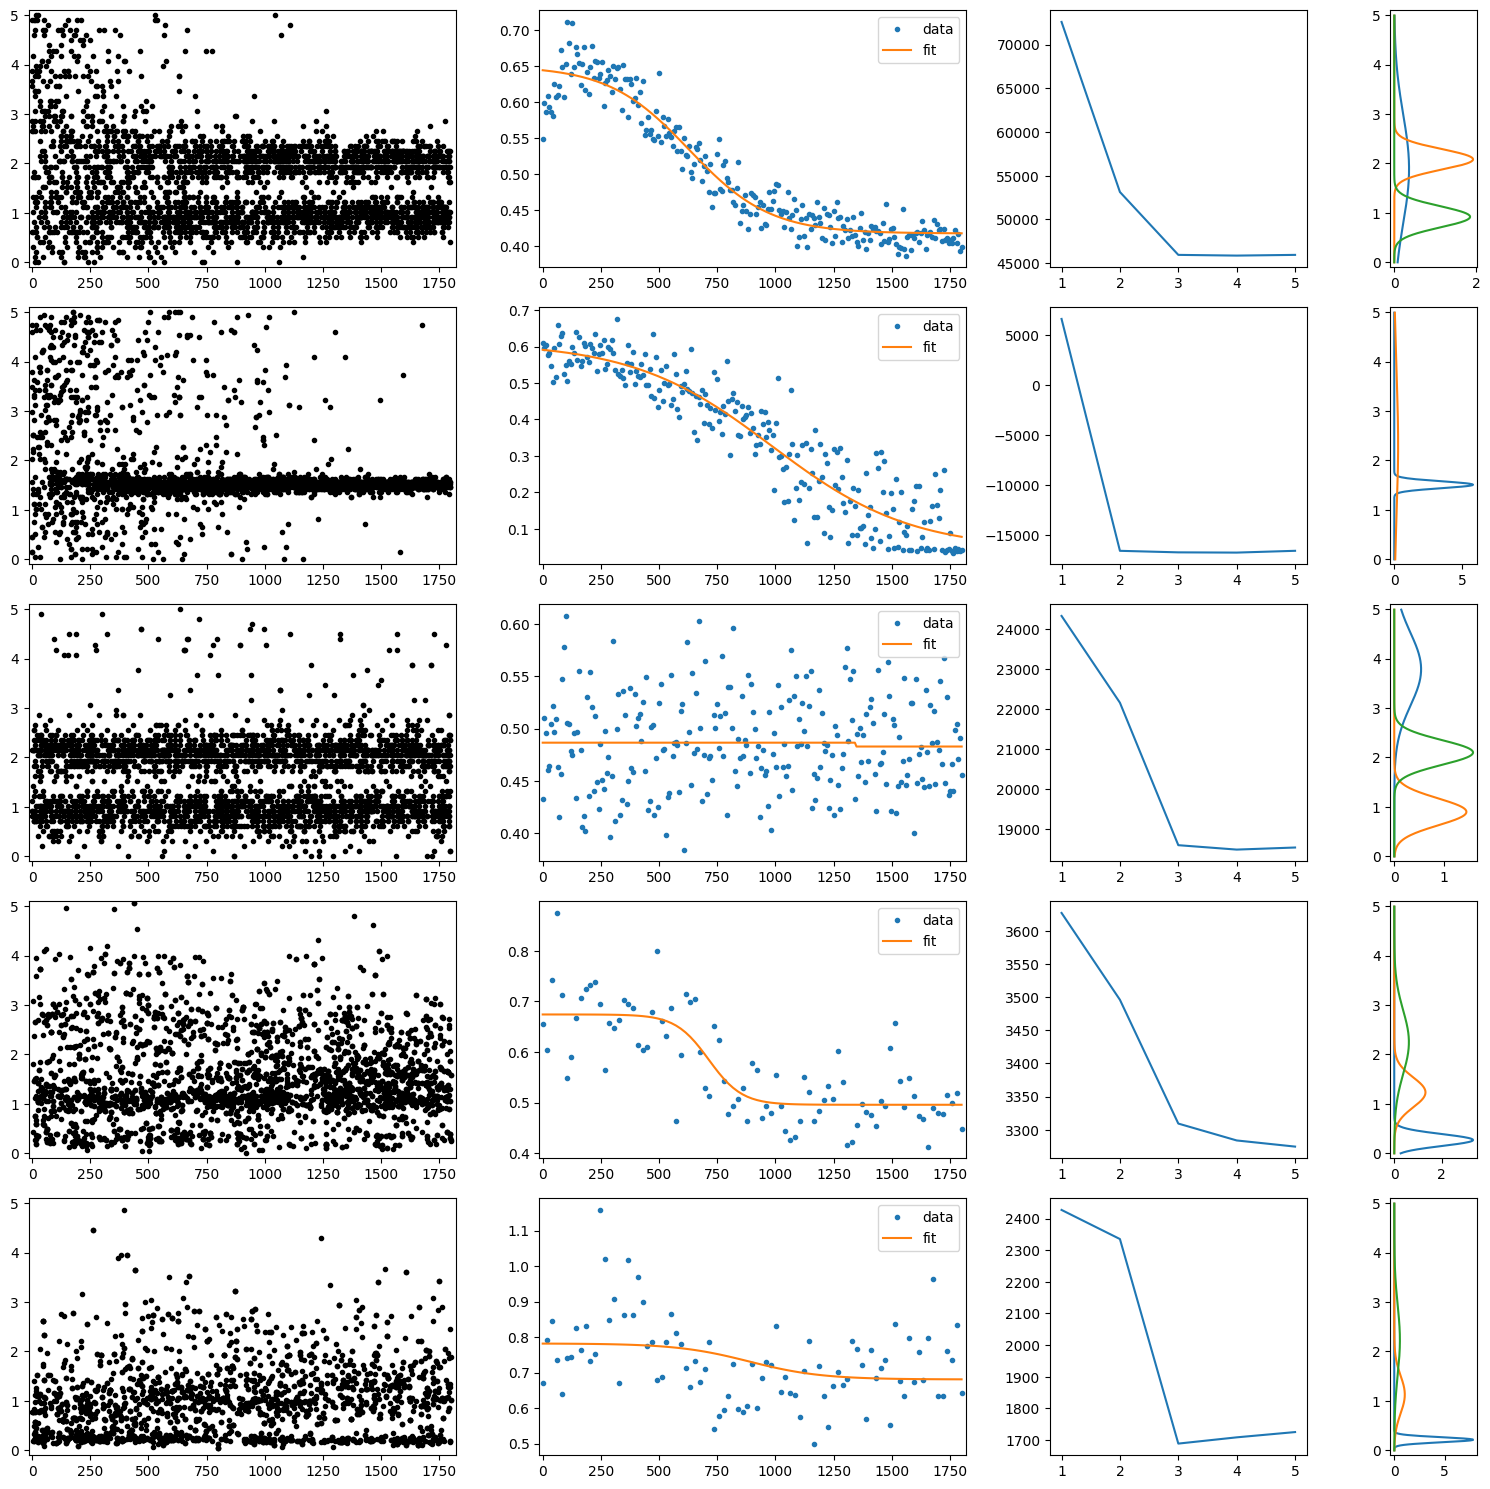

In [ ]:
#@title All plots

plt.close('all')
interval05 = [-0.1,5.1]
interval1800 = [-15,1820]
fig = plt.figure(figsize=(15,15))

ax11 = plt.subplot2grid((15, 9), (0, 0), colspan=3, rowspan=3)
ax21 = plt.subplot2grid((15, 9), (3, 0), colspan=3, rowspan=3)
ax31 = plt.subplot2grid((15, 9), (6, 0), colspan=3, rowspan=3)
ax41 = plt.subplot2grid((15, 9), (9, 0), colspan=3, rowspan=3)
ax51 = plt.subplot2grid((15, 9), (12, 0), colspan=3, rowspan=3)

ax12 = plt.subplot2grid((15, 9), (0, 3), colspan=3, rowspan=3)
ax22 = plt.subplot2grid((15, 9), (3, 3), colspan=3, rowspan=3)
ax32 = plt.subplot2grid((15, 9), (6, 3), colspan=3, rowspan=3)
ax42 = plt.subplot2grid((15, 9), (9, 3), colspan=3, rowspan=3)
ax52 = plt.subplot2grid((15, 9), (12, 3), colspan=3, rowspan=3)

ax13 = plt.subplot2grid((15, 9), (0, 6), colspan=2, rowspan=3)
ax23 = plt.subplot2grid((15, 9), (3, 6), colspan=2, rowspan=3)
ax33 = plt.subplot2grid((15, 9), (6, 6), colspan=2, rowspan=3)
ax43 = plt.subplot2grid((15, 9), (9, 6), colspan=2, rowspan=3)
ax53 = plt.subplot2grid((15, 9), (12, 6), colspan=2, rowspan=3)

ax14 = plt.subplot2grid((15, 9), (0, 8), colspan=1, rowspan=3)
ax24 = plt.subplot2grid((15, 9), (3, 8), colspan=1, rowspan=3)
ax34 = plt.subplot2grid((15, 9), (6, 8), colspan=1, rowspan=3)
ax44 = plt.subplot2grid((15, 9), (9, 8), colspan=1, rowspan=3)
ax54 = plt.subplot2grid((15, 9), (12, 8), colspan=1, rowspan=3)

ScatterPlot(times_EID,vocs_EID,ax11,25)
ScatterPlot(times_acc,vocs_acc,ax21,6)
ScatterPlot(times_noupdate,vocs_noupdate,ax31,7)
ScatterPlot(times_occ,vocs_occ,ax41,1)
ScatterPlot(times_vis,vocs_vis,ax51)
ax11.set_ylim(interval05)
ax21.set_ylim(interval05)
ax31.set_ylim(interval05)
ax41.set_ylim(interval05)
ax51.set_ylim(interval05)
ax11.set_xlim(interval1800)
ax21.set_xlim(interval1800)
ax31.set_xlim(interval1800)
ax41.set_xlim(interval1800)
ax51.set_xlim(interval1800)

DeviationSigmoid(deviations_xdata,deviations_EID,ax12)
DeviationSigmoid(deviations_xdata,deviations_acc,ax22)
DeviationSigmoid(deviations_xdata,deviations_noupdate,ax32)
DeviationSigmoid(deviations_xrealdata,deviations_occ,ax42)
DeviationSigmoid(deviations_xrealdata,deviations_vis,ax52)
ax12.set_xlim(interval1800)
ax22.set_xlim(interval1800)
ax32.set_xlim(interval1800)
ax42.set_xlim(interval1800)
ax52.set_xlim(interval1800)

Clustering(times_EID,vocs_EID,ax13)
Clustering(times_acc,vocs_acc,ax23)
Clustering(times_noupdate,vocs_noupdate,ax33)
Clustering(times_occ,vocs_occ,ax43)
Clustering(times_vis,vocs_vis,ax53)

PDFs(times_EID,vocs_EID,3,ax14)
PDFs(times_acc,vocs_acc,2,ax24)
PDFs(times_noupdate,vocs_noupdate,3,ax34)
PDFs(times_occ,vocs_occ,3,ax44)
PDFs(times_vis,vocs_vis,3,ax54)
ax14.set_ylim(interval05)
ax24.set_ylim(interval05)
ax34.set_ylim(interval05)
ax44.set_ylim(interval05)
ax54.set_ylim(interval05)

plt.tight_layout()
plt.show()
#plt.savefig("SimulationsAndData.svg", format="svg")

